# NOTE: Unfortunately the dataset provided in the HW did not load, however we found this dataset and starter code to predict last names and utilized this to still get the experience that the bonus would provide. the original code utilized an rnn, however the rnn was changed to a GRU in this method.

Dataset found here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html?highlight=rnn

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Japanese.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Korean.txt']
Slusarski


Now we have `category_lines`, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
`all_categories` (just a list of languages) and `n_categories` for later
reference.


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l
# libraries needed
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, -1), hidden.view(1, 1, -1))
        output = self.h2o(output.view(1, -1))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128  # Assuming this is the hidden size
# Replace n_letters and n_categories with appropriate values.
gru = GRU(n_letters, n_hidden, n_categories)

In [ ]:
print(gru)

GRU(
  (gru): GRU(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We\'ll get back the output (probability
of each language) and a next hidden state (which we keep for the next
step).


In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = gru(input, hidden)

For the sake of efficiency we don\'t want to be creating a new Tensor
for every step, so we will use `lineToTensor` instead of
`letterToTensor` and use slices. This could be further optimized by
precomputing batches of Tensors.


In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = gru(input[0], hidden)
print(output)

tensor([[-2.8996, -2.9450, -2.8192, -2.8009, -2.9319, -2.9012, -2.9696, -2.8859,
         -2.9610, -2.9327, -2.8130, -2.8183, -2.8641, -2.8643, -2.8836, -2.8907,
         -3.0064, -2.8682]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a `<1 x n_categories>` Tensor, where every
item is the likelihood of that category (higher is more likely).


Training
========

Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use `Tensor.topk` to get the index
of the greatest value:


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 3)


We will also want a quick way to get a training example (a name and its
language):


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Bosch
category = Polish / line = Zdunowski
category = Vietnamese / line = Bui
category = Irish / line = Naomhan
category = Korean / line = Suk
category = Arabic / line = Totah
category = Italian / line = Trucco
category = Scottish / line = Johnstone
category = Japanese / line = Ariwa
category = Japanese / line = Tsukawaki


Training the Network
====================

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it\'s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer
of the gru is `nn.LogSoftmax`.


In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss


In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the `train`
function returns both the output and loss we can print its guesses and
also keep track of loss for plotting. Since there are 1000s of examples
we print only every `print_every` examples, and take an average of the
loss.


In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 24s) 2.9031 Pakulski / Portuguese ✗ (Polish)
10000 10% (0m 53s) 2.9568 Mahorin / Greek ✗ (Russian)
15000 15% (1m 16s) 2.5619 Hierro / Portuguese ✗ (Spanish)
20000 20% (1m 40s) 3.0254 Aonghus / Portuguese ✗ (Irish)
25000 25% (2m 5s) 0.9697 Makuda / Japanese ✓
30000 30% (2m 30s) 0.9344 Cermak / Czech ✓
35000 35% (2m 54s) 2.4619 Stewart / German ✗ (Scottish)
40000 40% (3m 18s) 1.2248 Hyun  / Korean ✓
45000 45% (3m 42s) 0.7818 Sienkiewicz / Polish ✓
50000 50% (4m 6s) 0.9678 Dubicki / Polish ✓
55000 55% (4m 30s) 3.0771 Close / French ✗ (Greek)
60000 60% (4m 53s) 1.0205 Rademakers / Dutch ✓
65000 65% (5m 16s) 1.3785 Li / Chinese ✗ (Korean)
70000 70% (5m 40s) 1.1242 Herback / Czech ✓
75000 75% (6m 3s) 0.5530 Romijnsen / Dutch ✓
80000 80% (6m 26s) 0.5036 Maalouf / Arabic ✓
85000 85% (6m 49s) 0.9868 Gomes / Portuguese ✓
90000 90% (7m 13s) 5.2270 Andringa / Spanish ✗ (Dutch)
95000 95% (7m 36s) 1.6015 Kassis / Greek ✗ (Arabic)
100000 100% (8m 0s) 0.0381 Nomikos / Greek ✓


Plotting the Results
====================

Plotting the historical loss from `all_losses` shows the network
learning:


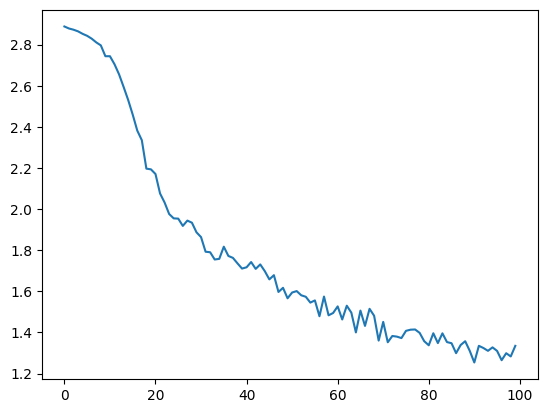

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with `evaluate()`,
which is the same as `train()` minus the backprop.


<ipython-input-44-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-44-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


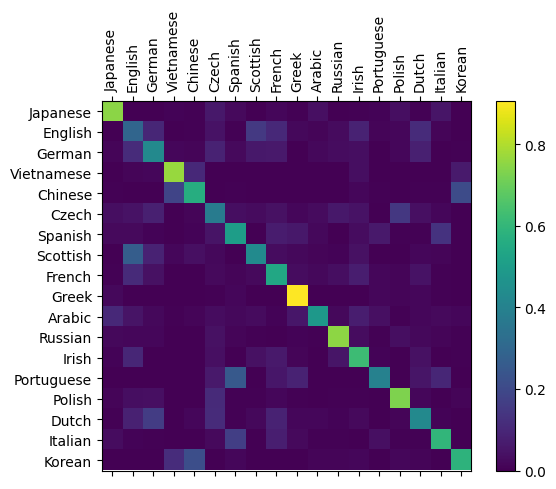

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).


Running on User Input
=====================


In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.46) Russian
(-1.48) Czech
(-2.41) Polish

> Jackson
(-0.40) Scottish
(-1.91) English
(-3.05) Czech

> Satoshi
(-0.42) Japanese
(-1.56) Arabic
(-2.67) Polish


In [ ]:
predict('Kalicak')
predict('Ritterbusch')
predict('Zabaras')


> Kalicak
(-0.36) Polish
(-1.35) Czech
(-3.65) Russian

> Ritterbusch
(-0.68) Czech
(-1.44) Russian
(-2.05) German

> Zabaras
(-0.32) Greek
(-2.10) Spanish
(-2.65) Portuguese


In [ ]:
import torch.nn.functional as F

log_probs = torch.tensor([-0.32, -2.10, -2.65])  # Example log probabilities
probs = F.softmax(log_probs, dim=0)
print(probs)


tensor([0.7899, 0.1332, 0.0769])
